# PHIGHT COVID Capstone - Visualization for Death Rate

Developed by Wei-Yu Tseng 

March, 2022

### Import Packages

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import panel as pn
import param
import datetime
sns.set_style("whitegrid")
# Set the style of graphs. 

### Data Cleaning

In [69]:
covid = pd.read_csv('/Users/weiyut/Downloads/deaths_teaching_mobility.csv')

covid = covid.rename(columns = {'date':'DATE', 'rev_newdeaths':'NEWDEATHS', 'rev_newconfirmed2': 'NEWCONFIRMED'})
# Rename columns we will be using. 
  
covid.DATE = pd.to_datetime(covid.DATE)
# Convert the Date columns to pandas datetime data type.

### Dashboard for Cases, Deaths, Death Rate

Easier to get multiple plots without plotting them all at once

In [70]:
County_options = list(covid.county.unique())
# Save the all counties to a list for the county options in the dashboard.  

County_options.append('Ohio State')
# Add Ohio State to the list. 
pn.extension()
class Deaths_Cases(param.Parameterized): #Dashboard object
    County = param.Selector(default = 'Ohio State', objects = County_options)
    # County Selection widgets, default setting is entire ohio state, selections include the entire Ohio state and all counties in Ohio. 
    
    Sigma = param.Integer(5, bounds=(0, 15))
    # Standard deviation for Gaussian Smoother. 0 means no smoothing. 
    
    Shift = param.Integer(14, bounds = (0,21))
    # Shift for Deaths. 0 means no shift. 
    
    Scaling_Death = param.Integer(50, bounds = (1,50))
    # Scaling multiplier for Deaths curve, to provide better visualization when comparing with Cases.
    
    Scaling_Rate = param.Selector(default= 100000, objects = [1, 25, 50, 100, 150, 200, 300, 400, 500, 1000, 10000, 100000])
    # Scaling multiplier for Death Rate curve, to provide better visualization when comparing with Cases and Deaths.
    
    Upper_bound = param.Number(10000.00, precedence=0.001)
    # Upper bound for y axis of the graph. 
    # Change it to lower value when looking at county level; 
    # Change it to below 1 when only looking at death rate. 
    
    Lower_bound = param.Number(0.00, precedence=0.001)
    # Lower bound for y axis of the graph. 
    Fall_2020_Semester_Only = param.Boolean(True)
    # Filter whether to show the data only during the 2020 Fall semester. 
    
    Death_Rate_Only = param.Boolean(False)
    # Show only Death Rate series.  
    
    
    
    def get_data(self): # The function to get the data frame to plot.
        df = covid.copy() 
        # Copy the data frame, so we won't accidentally change the original data frame.
        
        if self.County != 'Ohio State': # Filter the data frame to specific county(if we selection is one of the counties).      
            df = df[df.county == self.County]
        else: # Otherwise, if we look at state-wise data, group all data by date. 
            df = df.groupby(df.DATE).sum([['NEWDEATHS', 'NEWCONFIRMED']]).reset_index()

        df['Deaths_shift'] = df.NEWDEATHS.shift(-self.Shift)
        # Create a new column for Shifting Deaths.  
        return df
    
    def graph(self): # The function for the graphs we would like to display.
        df = self.get_data() 
        # Get the data we manipulated from the get_data() function.
        
        fig = plt.figure(figsize = (8,6))
        # Set the figure size, and store it to a varaible that allows us to return later. 
        
        sigma = self.Sigma
        # Get the standard deviation we selected for Gaussian filter.  
        
        if self.Death_Rate_Only: # If we decide to plot only death rate.
            plt.plot(df.DATE, gaussian_filter(df.Deaths_shift, sigma = sigma)/gaussian_filter(df.NEWCONFIRMED,sigma = sigma), label = 'Gaussian Filter ('+ r'$\sigma$ ='+str(sigma)+')')
            # Plot the smoothed death rate.
            
            plt.plot(df.DATE, df.Deaths_shift/df.NEWCONFIRMED, label = 'Death Rate(Raw)', alpha= 0.2, color = '#00ccff')
            # Plot the raw death rate. 
            
            plt.title('Death Rate of ' + self.County, fontsize = 10)
            # Plot the title.
            
            
        else: # Otherwise, show everything. 
            plt.plot(df.DATE, gaussian_filter(df.NEWCONFIRMED, sigma = sigma), label = 'Cases')
            # Plot the smoothed daily new confirmed cases. 

            plt.plot(df.DATE, self.Scaling_Death*gaussian_filter(df.Deaths_shift,sigma = sigma), label ='Shifted Death Cases(Up scaled '+ str(self.Scaling_Death) +' times)' )
            # Plot the upscaling smoothed daily new deaths.

            plt.plot(df.DATE, self.Scaling_Rate*gaussian_filter(df.Deaths_shift, sigma = sigma)/gaussian_filter(df.NEWCONFIRMED,sigma = sigma), label = 'Shifted Death Rate(Up scaled '+ str(self.Scaling_Rate) +' times)')
            # Plot the upscaling smoothed death rate.
            
            plt.title(str(self.Shift)+' days shift of '+ self.County +', Gaussian Filter ('+ r'$\sigma$ ='+str(sigma)+')', fontsize = 10)
            # Plot the title.

        
        plt.xticks(rotation = 30,fontsize = 10)
        # Customize the style of x axis. 
        if self.Fall_2020_Semester_Only: # Whether choosing to look only at the data during the semester. 
            plt.xlim([datetime.date(2020, 8, 15), datetime.date(2020, 12, 15)])
        
        plt.ylim(self.Lower_bound, self.Upper_bound)
        # Decide the range of y axis(number of cases). 
        
        plt.ylabel('')
        # Customization of the y axis label. 
        
        plt.legend(fontsize = 10)
        # Customization of the legend. 
        
        
        plt.close()
        return fig

        

In [73]:
# Dashboard Arrangement.
dash = Deaths_Cases(name = '')
dashboard = pn.Row(dash.param,
                   dash.graph)

<ipython-input-70-7c286ea3216c>:76: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(df.DATE, self.Scaling_Rate*gaussian_filter(df.Deaths_shift, sigma = sigma)/gaussian_filter(df.NEWCONFIRMED,sigma = sigma), label = 'Shifted Death Rate(Up scaled '+ str(self.Scaling_Rate) +' times)')
<ipython-input-70-7c286ea3216c>:76: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(df.DATE, self.Scaling_Rate*gaussian_filter(df.Deaths_shift, sigma = sigma)/gaussian_filter(df.NEWCONFIRMED,sigma = sigma), label = 'Shifted Death Rate(Up scaled '+ str(self.Scaling_Rate) +' times)')


Row
    [0] Column(margin=5, width=300)
        [0] StaticText(value='<b></b>')
        [1] Select(name='County', options=OrderedDict([('ADAMS', ...]), value='Ohio State')
        [2] IntSlider(end=15, name='Sigma', value=5)
        [3] IntSlider(end=21, name='Shift', value=14)
        [4] IntSlider(end=50, name='Scaling Death', start=1, value=50)
        [5] Select(name='Scaling Rate', options=OrderedDict([('1', ...]), value=100000)
        [6] Checkbox(name='Fall 2020 Semester Only', value=True)
        [7] Checkbox(name='Death Rate Only')
        [8] FloatInput(name='Upper bound', value=10000.0)
        [9] FloatInput(name='Lower bound')
    [1] ParamMethod(method)
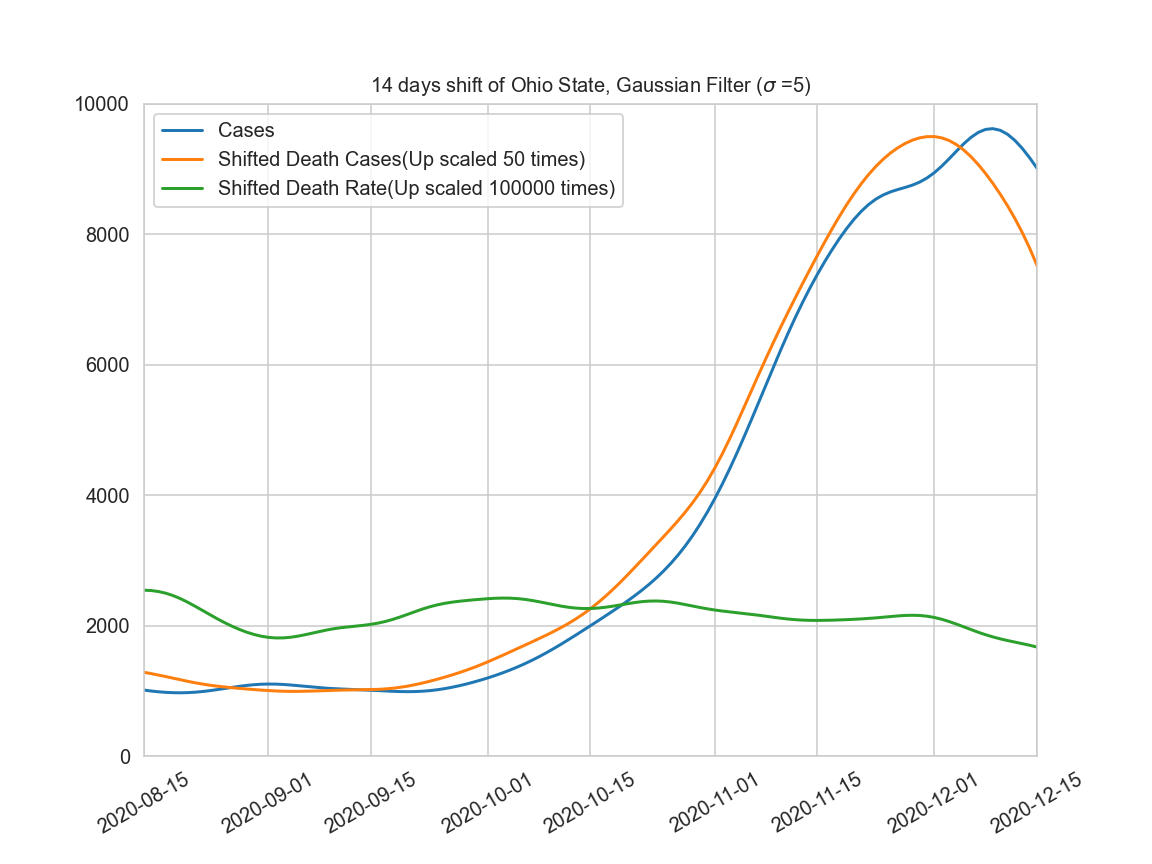

In [74]:
# Display Dashboard.
dashboard

In [ ]:
dashboard.servable()
# Run in prompt if you want to deploy the dashboard in another window: 
# panel serve --show Death_Rate.ipynb